In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
from datetime import datetime
import os

In [5]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/kevin/Downloads/Northwestern University/Data Science/STAT_390


In [6]:
# TO DO: Needs to be changed to the correct working directory

os.chdir("/Users/kevin/Downloads/Northwestern University/Data Science/STAT_390")
print("New Working Directory:", os.getcwd())

New Working Directory: /Users/kevin/Downloads/Northwestern University/Data Science/STAT_390


### Week 4 Progress

In [42]:
# Generate Contour-Based Epithelium Mask. Credit: Team 2

def generate_epithelium_mask_old(image_path):
    
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return contour_mask, contours, image

In [43]:
# Creating Superpixels and Cutting Along Contour Boundaries
def create_and_cut_superpixels_old(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    
    segmented_image = np.zeros_like(image_rgb)
    lower_purple = np.array([125, 40, 40])
    upper_purple = np.array([155, 255, 255])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]
            inside_hsv = cv2.cvtColor(inside_segment, cv2.COLOR_RGB2HSV)
            purple_inside_mask = cv2.inRange(inside_hsv, lower_purple, upper_purple)
            
            # Calculate purple concentration inside
            total_pixels_inside = np.sum(inside_segment[:, :, 0] > 0)
            purple_pixels_inside = np.sum(purple_inside_mask > 0)
            purple_concentration_inside = purple_pixels_inside / total_pixels_inside if total_pixels_inside > 0 else 0

            # Assign colors based on purple concentration for inside
            if purple_concentration_inside > 0.15:
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif purple_concentration_inside > 0.015:
                segmented_image[inside_mask] = [255, 255, 255]
            else:
                segmented_image[inside_mask] = [0, 0, 0]

        # Process outside region (background)
        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]  # Assign black to outside background

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image Using Week 4's Algorithm")
    plt.axis('off')
    plt.show()
    
    return segmented_image

In [46]:
# Combining both steps
def extract_epithelium_old(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask_old(image_path)
    segmented_image = create_and_cut_superpixels_old(original_image, contour_mask, contours)

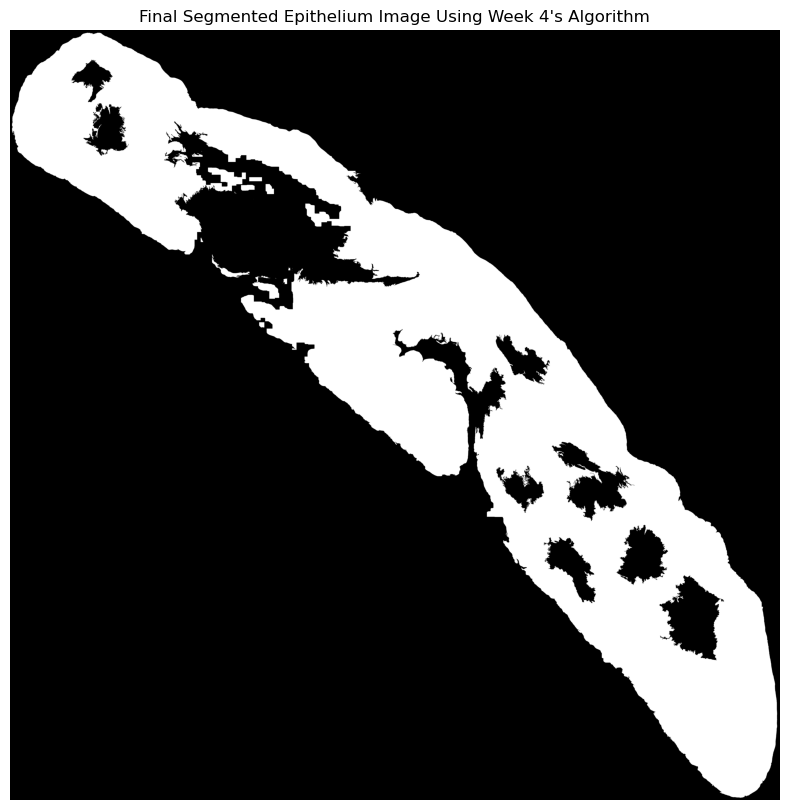

In [48]:
extract_epithelium_old('Tissue Slices/H&E/h1810898A  h&e_ROI_1.tif')

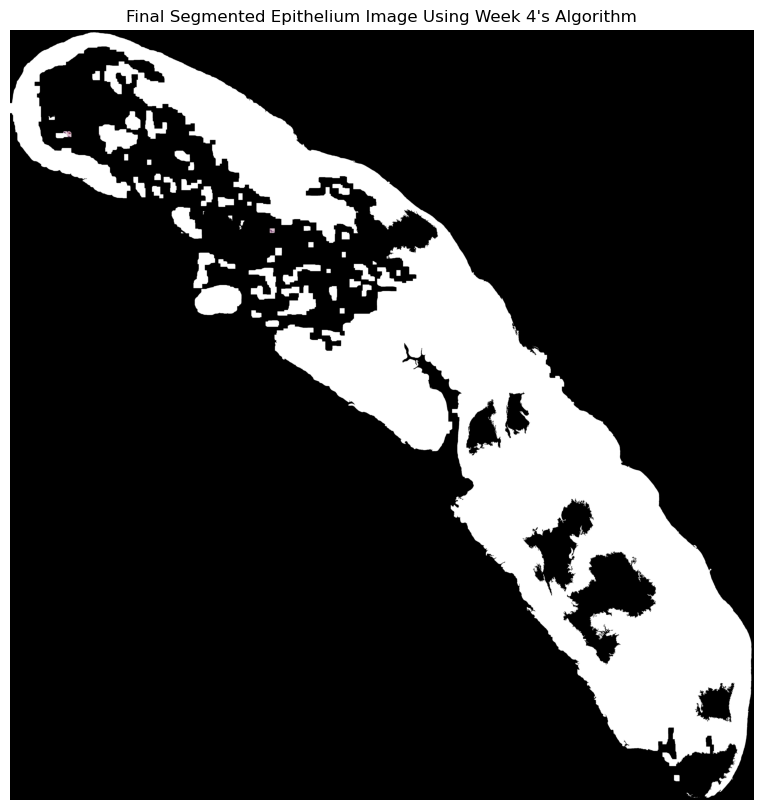

In [49]:
extract_epithelium_old('Tissue Slices/H&E/h1810898A  h&e_ROI_2.tif')

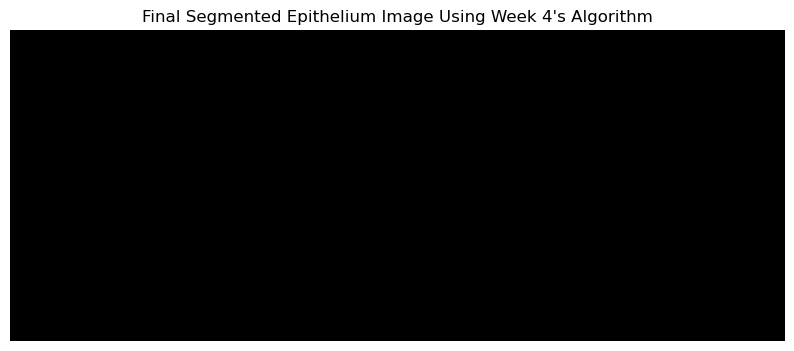

In [47]:
extract_epithelium_old('Tissue Slices/Melan-A/h1812404A melan a_ROI_1.tif')

# <font color = 'purple'>Strategy 1: Generalizing the "purple" cut-off using YUV format</font>

In [34]:
# Generate Contour-Based Epithelium Mask. Credit: Team 2

def generate_epithelium_mask(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological transformations
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return contour_mask, contours, image

In [35]:
# Create and Segment Superpixels Using YUV Luma

def create_and_cut_superpixels(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)   #### YUV
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    segmented_image = np.zeros_like(image_rgb)
    
    luma_channel = yuv_image[:, :, 0]
    stroma_threshold_low, stroma_threshold_high = 180, 300  # Stroma
    epithelium_threshold_low, epithelium_threshold_high = 80, 180  # Epithelium

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        if np.sum(inside_mask) > 0:
            luma_values = luma_channel[inside_mask]
            avg_luma = np.mean(luma_values)

            # Classify based on luma values
            if epithelium_threshold_low <= avg_luma <= epithelium_threshold_high:
                segmented_image[inside_mask] = image_rgb[inside_mask]  # Epithelium
            elif stroma_threshold_low <= avg_luma <= stroma_threshold_high:
                segmented_image[inside_mask] = [255, 255, 255]  # Stroma
            else:
                segmented_image[inside_mask] = [0, 0, 0]  # Background

        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]

    # Display final segmented image
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image")
    plt.axis('off')
    plt.show()

    return segmented_image

In [36]:
# Combine both steps

def extract_epithelium(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = create_and_cut_superpixels(original_image, contour_mask, contours)
    
    # Save the final result
    output_path = f"Extracted Epithelium/{image_path.split('/')[-1].replace('.tif', '_extracted.tif')}"
    cv2.imwrite(output_path, cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))
    print(f"Saved final segmented image as {output_path}")

## Testing

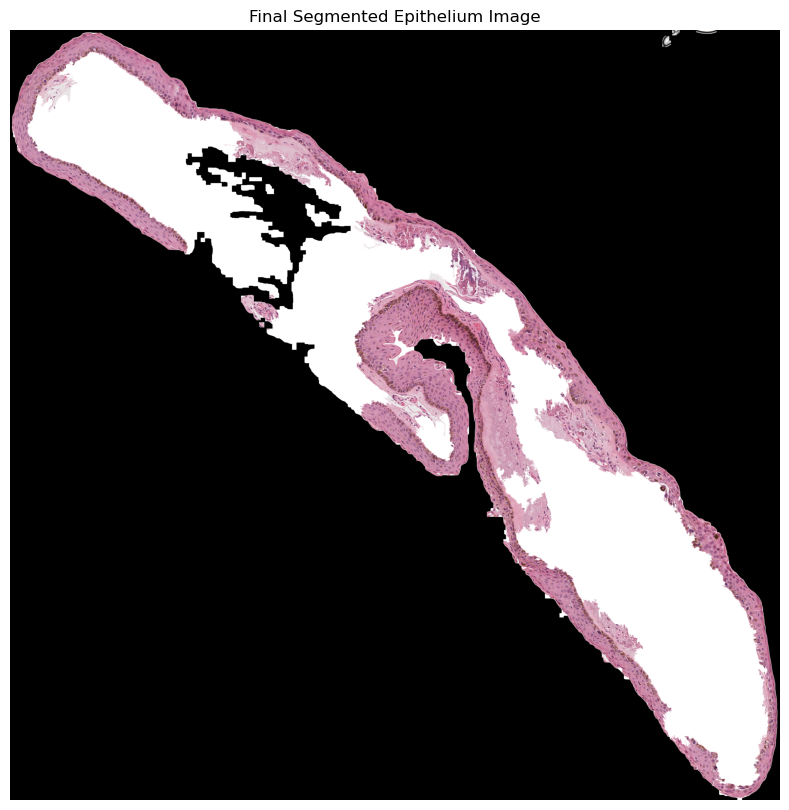

Saved final segmented image as Extracted Epithelium/h1810898A  h&e_ROI_1_extracted.tif


In [37]:
extract_epithelium('Tissue Slices/H&E/h1810898A  h&e_ROI_1.tif')

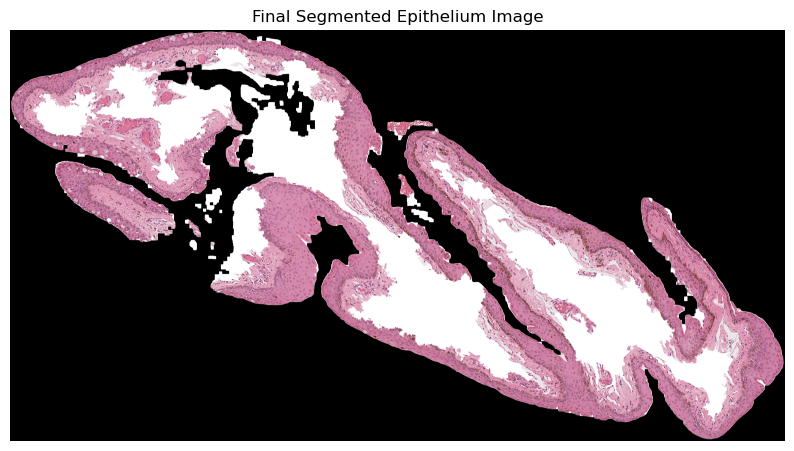

Saved final segmented image as Extracted Epithelium/h1812404B  h&e_ROI_3_extracted.tif


In [27]:
extract_epithelium('Tissue Slices/H&E/h1812404B  h&e_ROI_3.tif')

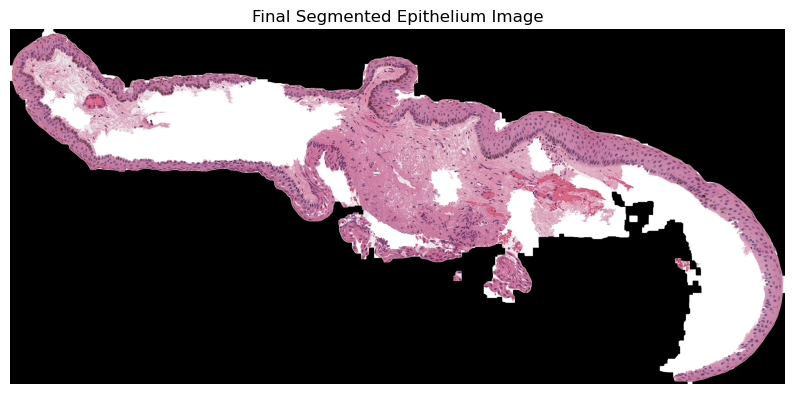

Saved final segmented image as Extracted Epithelium/h1825421  h&e_ROI_3_extracted.tif


In [29]:
extract_epithelium('Tissue Slices/H&E/h1825421  h&e_ROI_3.tif')

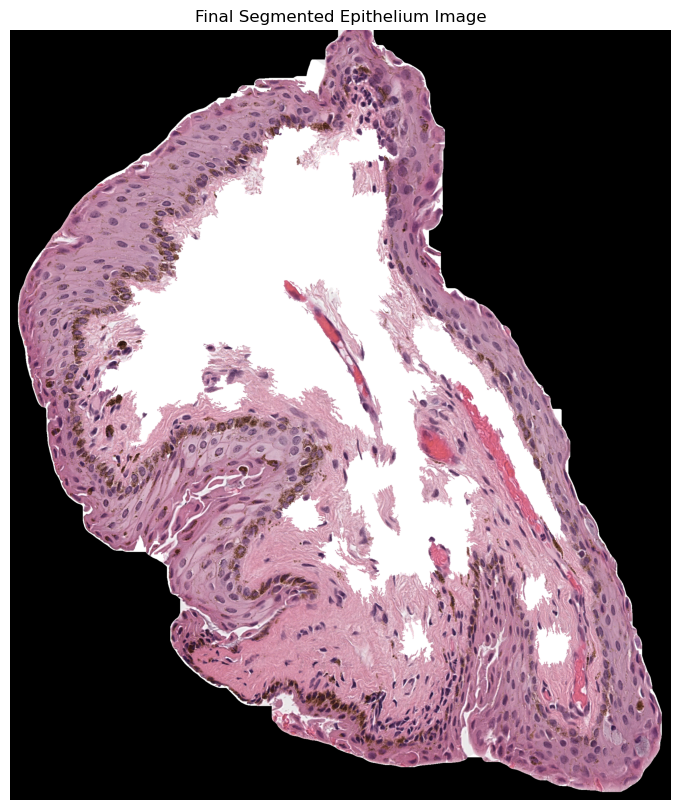

Saved final segmented image as Extracted Epithelium/h1817608C  h&e_ROI_1_extracted.tif


In [50]:
extract_epithelium('Tissue Slices/H&E/h1817608C  h&e_ROI_1.tif')

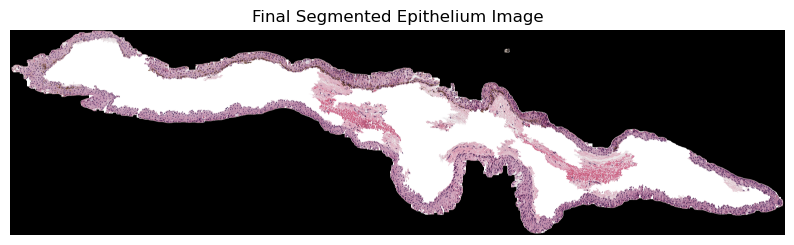

Saved final segmented image as Extracted Epithelium/H1844192  h&e_ROI_1_extracted.tif


In [31]:
extract_epithelium('Tissue Slices/H&E/H1844192  h&e_ROI_1.tif')

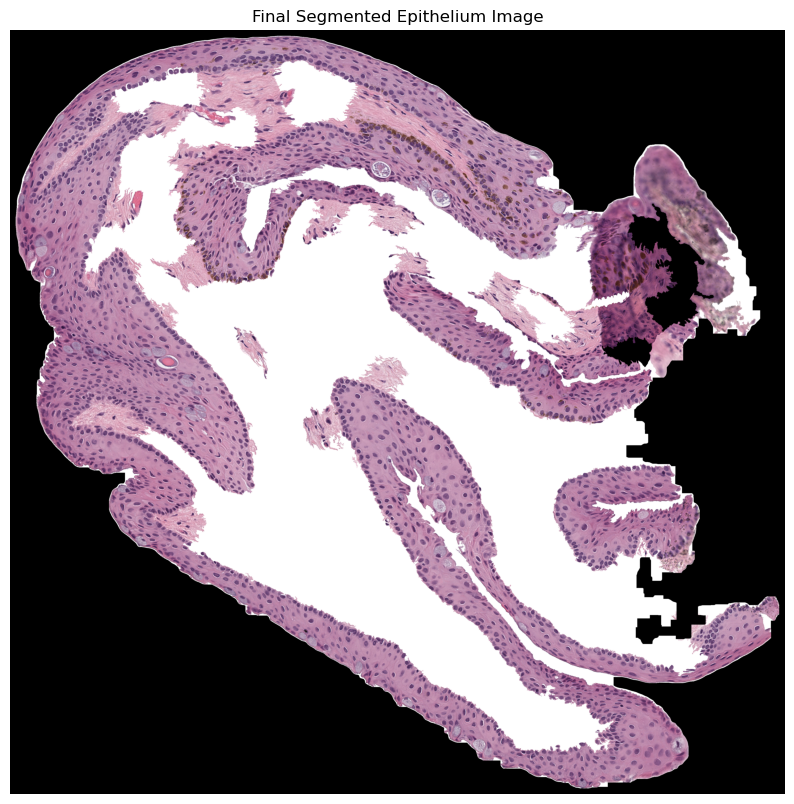

Saved final segmented image as Extracted Epithelium/h1849462  h&e_ROI_1_extracted.tif


In [33]:
extract_epithelium('Tissue Slices/H&E/h1849462  h&e_ROI_1.tif')

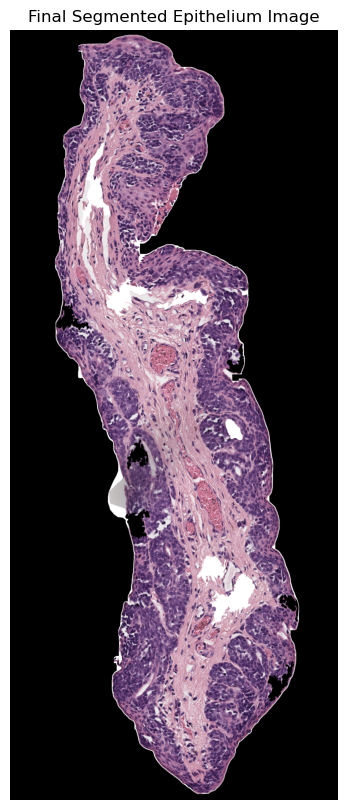

Saved final segmented image as Extracted Epithelium/image2_extracted.tif


In [32]:
extract_epithelium('Tissue Slices/H&E/image2.tif')

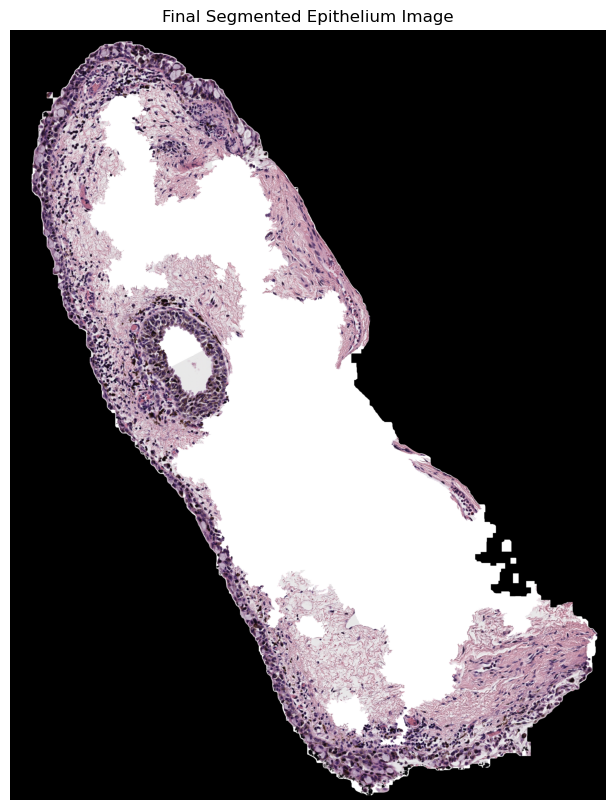

Saved final segmented image as Extracted Epithelium/HighQualitySample2_extracted.tif


In [38]:
extract_epithelium('Tissue Slices/H&E/HighQualitySample2.tif')

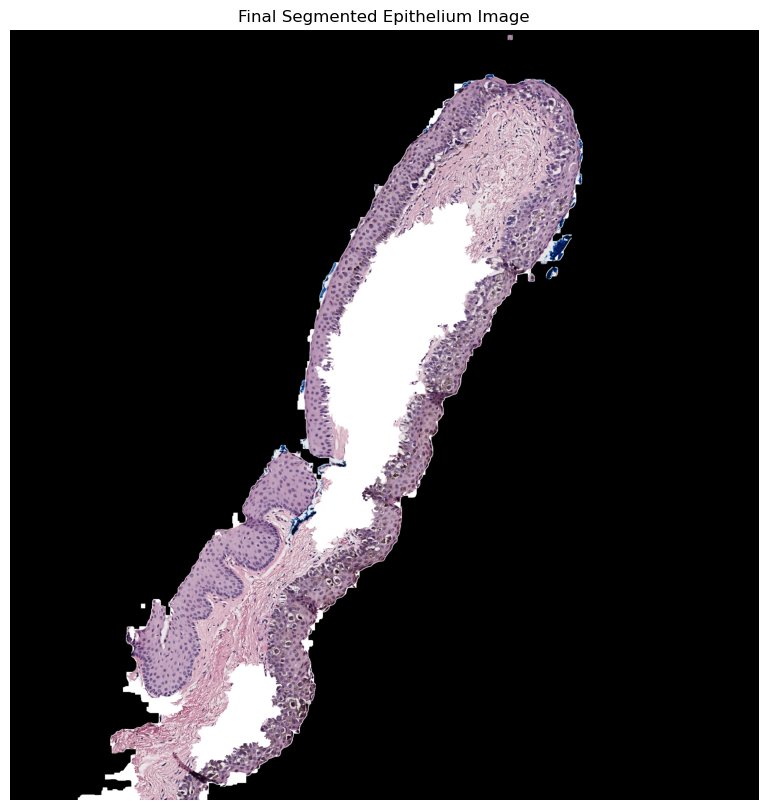

Saved final segmented image as Extracted Epithelium/HighQualitySample4_extracted.tif


In [39]:
extract_epithelium('Tissue Slices/H&E/HighQualitySample4.tif')

## Testing on Melan-A

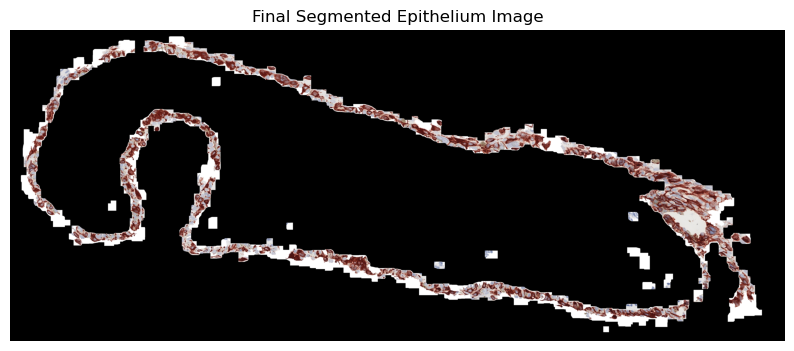

Saved final segmented image as Extracted Epithelium/h1812404A melan a_ROI_1_extracted.tif


In [41]:
extract_epithelium('Tissue Slices/Melan-A/h1812404A melan a_ROI_1.tif')

## Testing on Sox-10

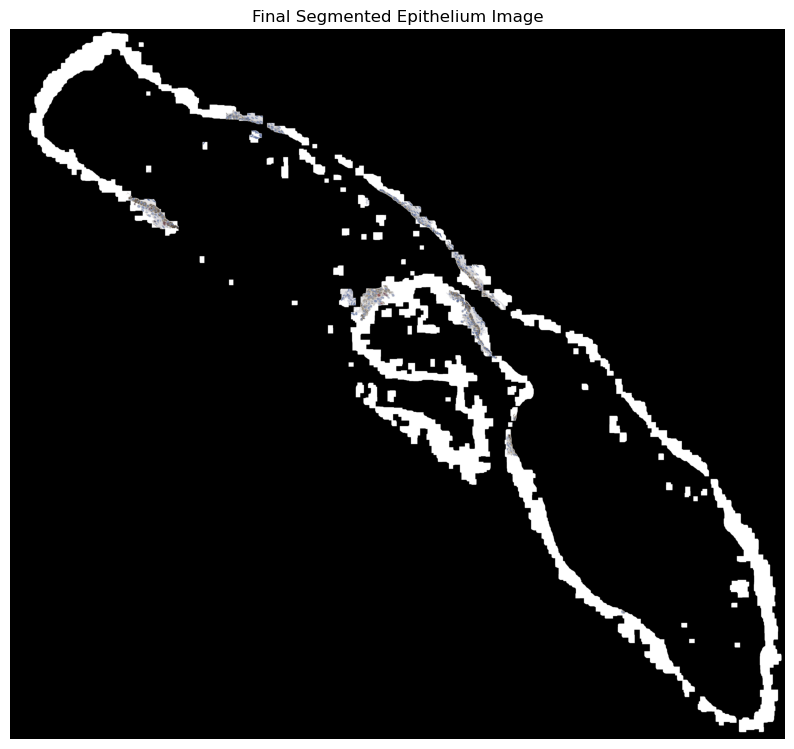

Saved final segmented image as Extracted Epithelium/h1810898A sox10_ROI_1_extracted.tif


In [40]:
extract_epithelium('Tissue Slices/Sox-10/h1810898A sox10_ROI_1.tif')